In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_recall_curve, auc, roc_curve

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib
import math
import datetime
import time
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define headers for the dataset
header = [
    "timestamp",
    "cpu_usage",
    "top_1_cpu_proc_name",
    "top_1_cpu_proc_usage",
    "top_2_cpu_proc_name",
    "top_2_cpu_proc_usage",
    "top_3_cpu_proc_name",
    "top_3_cpu_proc_usage",
    "top_4_cpu_proc_name",
    "top_4_cpu_proc_usage",
    "top_5_cpu_proc_name",
    "top_5_cpu_proc_usage",
    "mem_usage",
    "top_1_mem_proc_name",
    "top_1_mem_proc_usage",
    "top_2_mem_proc_name",
    "top_2_mem_proc_usage",
    "top_3_mem_proc_name",
    "top_3_mem_proc_usage",
    "top_4_mem_proc_name",
    "top_4_mem_proc_usage",
    "top_5_mem_proc_name",
    "top_5_mem_proc_usage",
    "nginx_active_connections",
    "nginx_rps"
]

# Load the dataset with semicolon delimiter
df = pd.read_csv(
    "drive/MyDrive/Colab Notebooks/dataset/system_stats.csv",
    header=None,
    names=header,
    sep=';',
    low_memory=False,
    on_bad_lines='skip'
)

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

# Handle timestamp parsing
df['timestamp'] = df['timestamp'].str.replace('T', ' ')
df['timestamp'] = df['timestamp'].str.split('.').str[0]

try:
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
except:
    print("Warning: Some timestamp parsing failed, using a more flexible approach")
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Drop rows with invalid timestamps
df = df.dropna(subset=['timestamp'])
print(f"Dataset shape after cleaning timestamps: {df.shape}")

# Convert numerical columns from strings to float
numeric_cols = [
    'cpu_usage', 'top_1_cpu_proc_usage', 'top_2_cpu_proc_usage',
    'top_3_cpu_proc_usage', 'top_4_cpu_proc_usage', 'top_5_cpu_proc_usage',
    'mem_usage', 'top_1_mem_proc_usage', 'top_2_mem_proc_usage',
    'top_3_mem_proc_usage', 'top_4_mem_proc_usage', 'top_5_mem_proc_usage',
    'nginx_active_connections', 'nginx_rps'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Select only numerical features for the models
numerical_features = [
    'cpu_usage', 'top_1_cpu_proc_usage', 'top_2_cpu_proc_usage',
    'top_3_cpu_proc_usage', 'top_4_cpu_proc_usage', 'top_5_cpu_proc_usage',
    'mem_usage', 'top_1_mem_proc_usage', 'top_2_mem_proc_usage',
    'top_3_mem_proc_usage', 'top_4_mem_proc_usage', 'top_5_mem_proc_usage',
    'nginx_active_connections', 'nginx_rps'
]

# Check for and handle missing values
print(f"Missing values:\n{df[numerical_features].isna().sum()}")
df[numerical_features] = df[numerical_features].fillna(0)

# Normalize the data for the autoencoder
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[numerical_features]),
    columns=numerical_features
)

# Save the scaler for future use
joblib.dump(scaler, '/content/drive/MyDrive/Colab Notebooks/feature_scaler.pkl')

# Split the data for autoencoder training
X_train_ae, X_test_ae = train_test_split(df_scaled, test_size=0.2, random_state=42)

Mounted at /content/drive
Dataset shape: (189381, 25)
Dataset shape after cleaning timestamps: (189381, 25)
Missing values:
cpu_usage                   0
top_1_cpu_proc_usage        0
top_2_cpu_proc_usage        0
top_3_cpu_proc_usage        0
top_4_cpu_proc_usage        0
top_5_cpu_proc_usage        0
mem_usage                   0
top_1_mem_proc_usage        0
top_2_mem_proc_usage        0
top_3_mem_proc_usage        0
top_4_mem_proc_usage        0
top_5_mem_proc_usage        0
nginx_active_connections    0
nginx_rps                   0
dtype: int64


Autoencoder Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,134 (27.87 KB)

 Trainable params: 7,134 (27.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0121 - val_loss: 7.8047e-04
Epoch 2/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0014 - val_loss: 6.5608e-04
Epoch 3/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0011 - val_loss: 6.0067e-04
Epoch 4/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0010 - val_loss: 5.6751e-04
Epoch 5/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 9.6019e-04 - val_loss: 5.5232e-04
Epoch 6/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 9.2845e-04 - val_loss: 5.5022e-04
Epoch 7/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 9.1235e-04 - val_loss: 5.7007e-04
Epoch 8/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 8.9277e-04 - val_loss: 5.1593e-04
Epoch 9/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 8.6793e-04 - val_loss: 5.3882e-04
Epoch 10/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 8.5063e-04 - val_loss: 5.3376e-04
Epoch 11/30
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 15

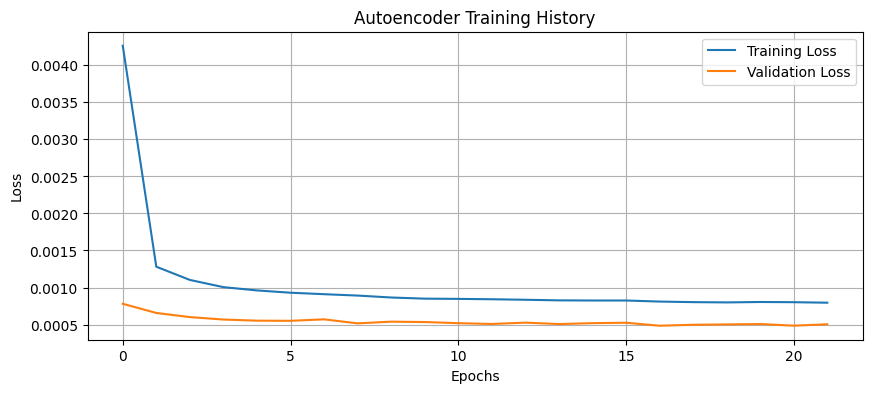

5919/5919 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

===== Autoencoder Evaluation Metrics =====
MAE: 0.010067
MSE: 0.000485
RMSE: 0.022011

===== Feature-wise Reconstruction Errors =====
                     Feature       MAE       MSE      RMSE
12  nginx_active_connections  0.020739  0.001217  0.034889
2       top_2_cpu_proc_usage  0.017447  0.000976  0.031242
1       top_1_cpu_proc_usage  0.021171  0.000899  0.029988
6                  mem_usage  0.016315  0.000864  0.029388
0                  cpu_usage  0.010039  0.000795  0.028191
8       top_2_mem_proc_usage  0.017290  0.000586  0.024212
7       top_1_mem_proc_usage  0.006321  0.000368  0.019178
3       top_3_cpu_proc_usage  0.005957  0.000332  0.018229
11      top_5_mem_proc_usage  0.012845  0.000256  0.015986
9       top_3_mem_proc_usage  0.005590  0.000152  0.012313
4       top_4_cpu_proc_usage  0.002249  0.000131  0.011456
10      top_4_mem_proc_usage  0.004044  0.000122  0.011065
5       top_5_cpu_proc_usage  0.000818  0.000075  0.008

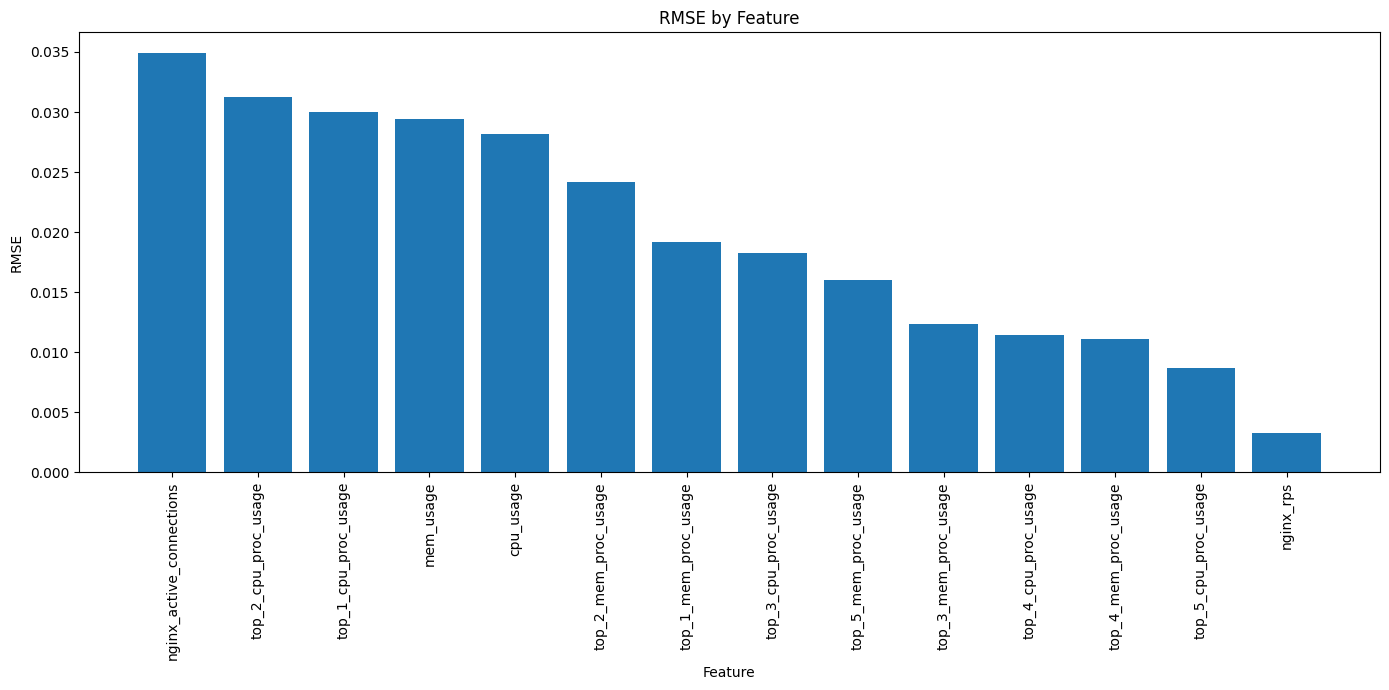

Anomaly threshold: 0.0033099502156773695
Number of anomalies detected: 3114 (1.64%)


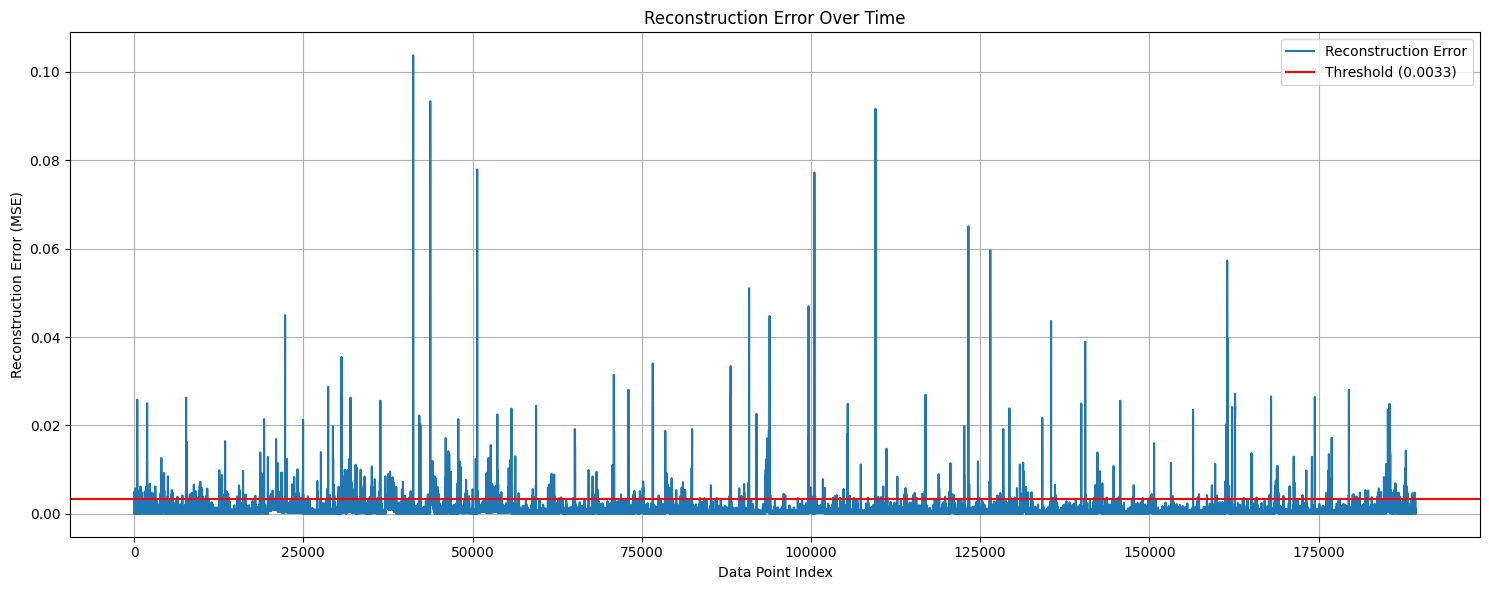

Top 10 anomalies by reconstruction error:


,timestamp,cpu_usage,mem_usage,nginx_rps,reconstruction_error
41227,2025-02-19 15:11:59,100.0,55.7,3.33,0.103755
43754,2025-02-20 01:43:55,100.0,85.8,27.14,0.093358
109543,2025-03-03 12:13:20,100.0,56.4,7.91,0.091644
109535,2025-03-03 12:11:20,88.6,55.1,7.84,0.085976
109536,2025-03-03 12:11:35,92.5,56.6,7.12,0.079624
50684,2025-02-21 06:38:17,100.0,85.1,13.17,0.077910
100508,2025-03-01 22:33:31,22.5,25.5,6597.96,0.077204
100507,2025-03-01 22:33:31,22.5,25.5,6597.93,0.075749
109539,2025-03-03 12:12:20,44.3,53.5,8.31,0.068811
109541,2025-03-03 12:12:50,75.0,54.6,7.73,0.066538


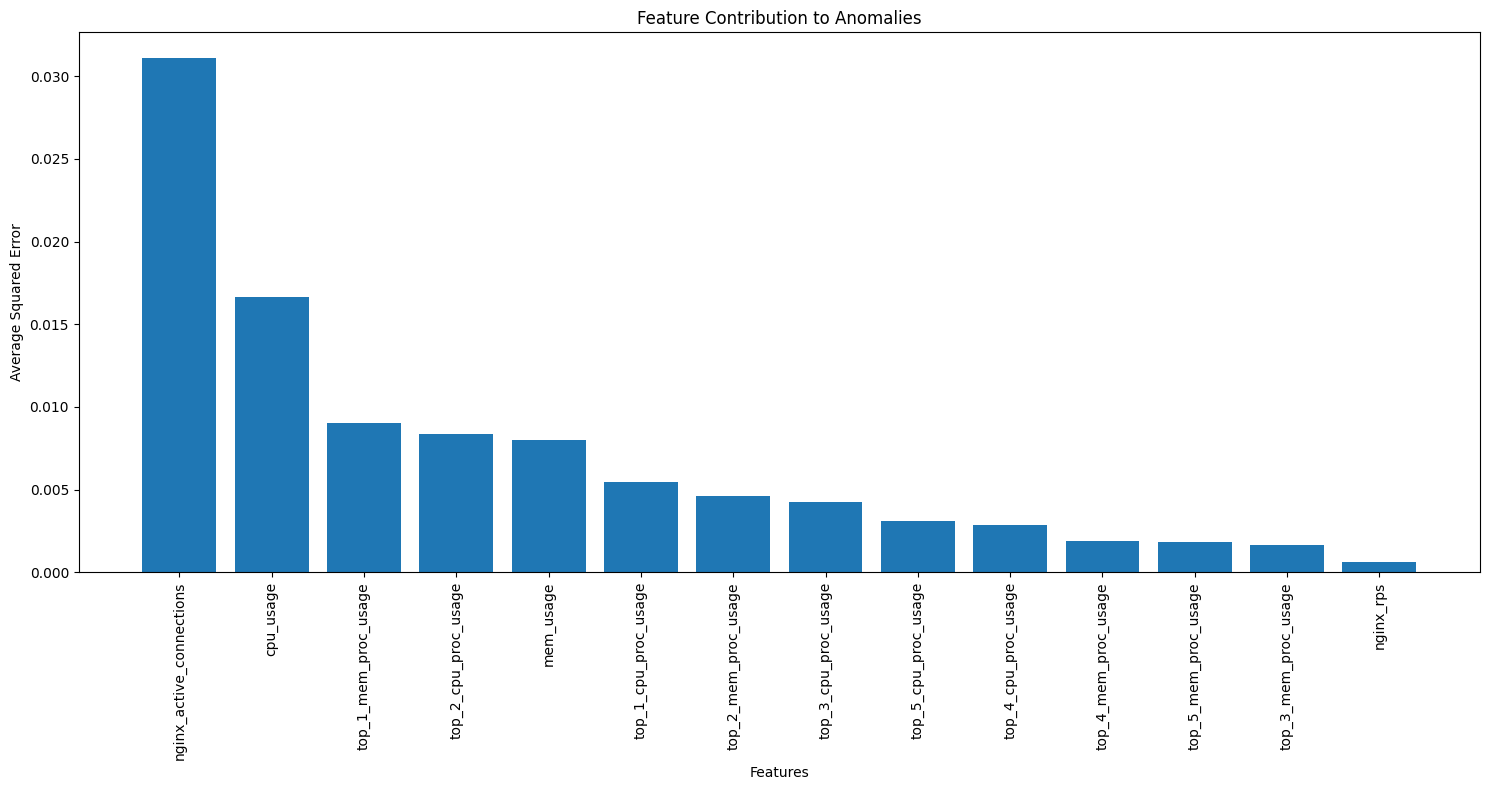

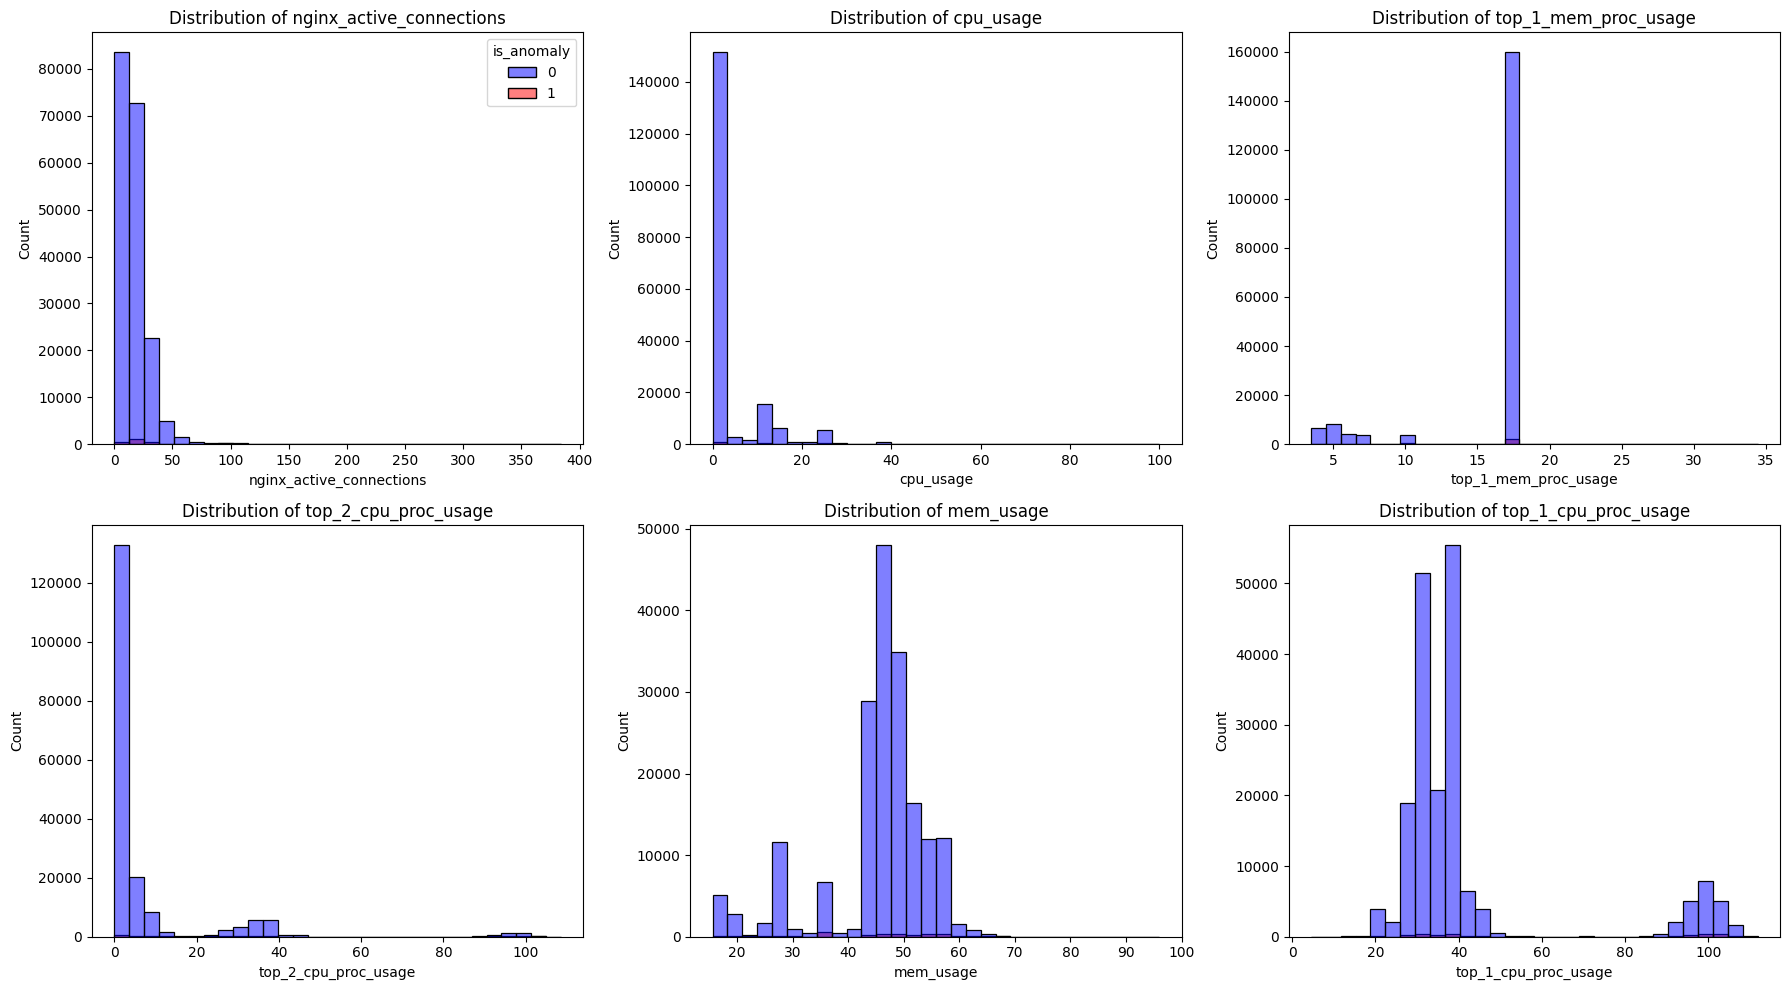

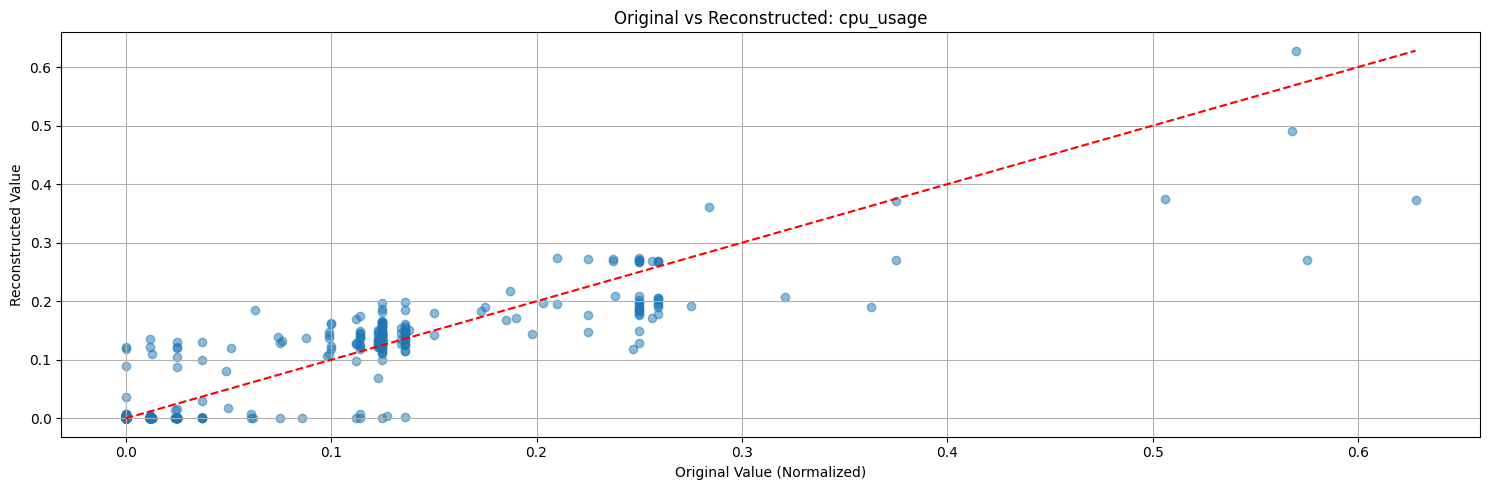

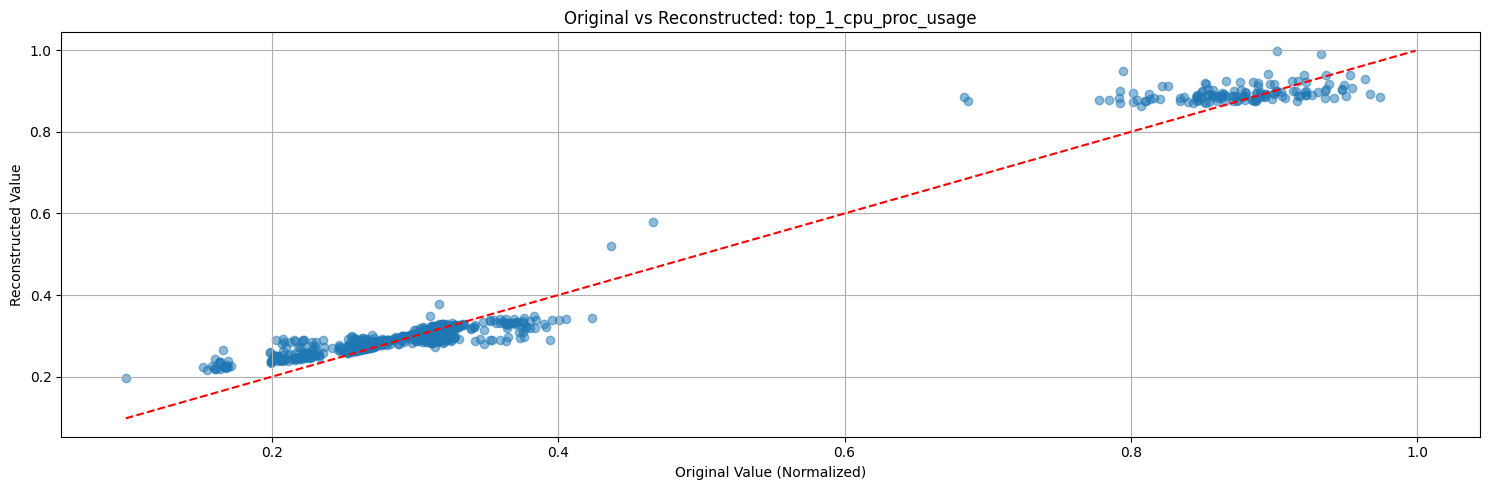

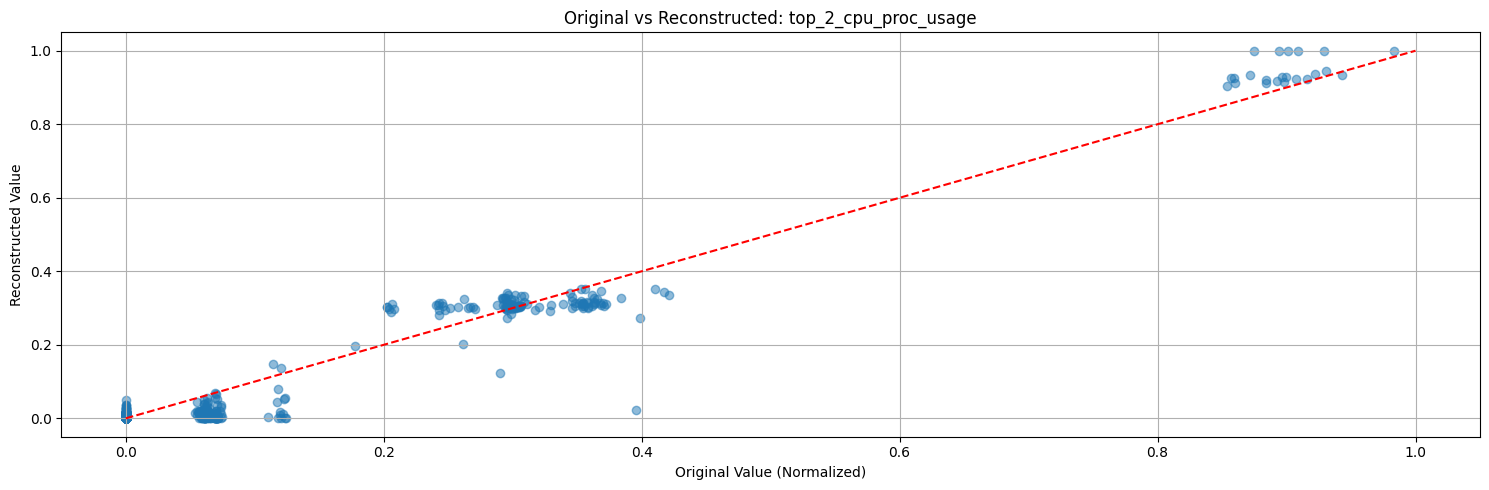

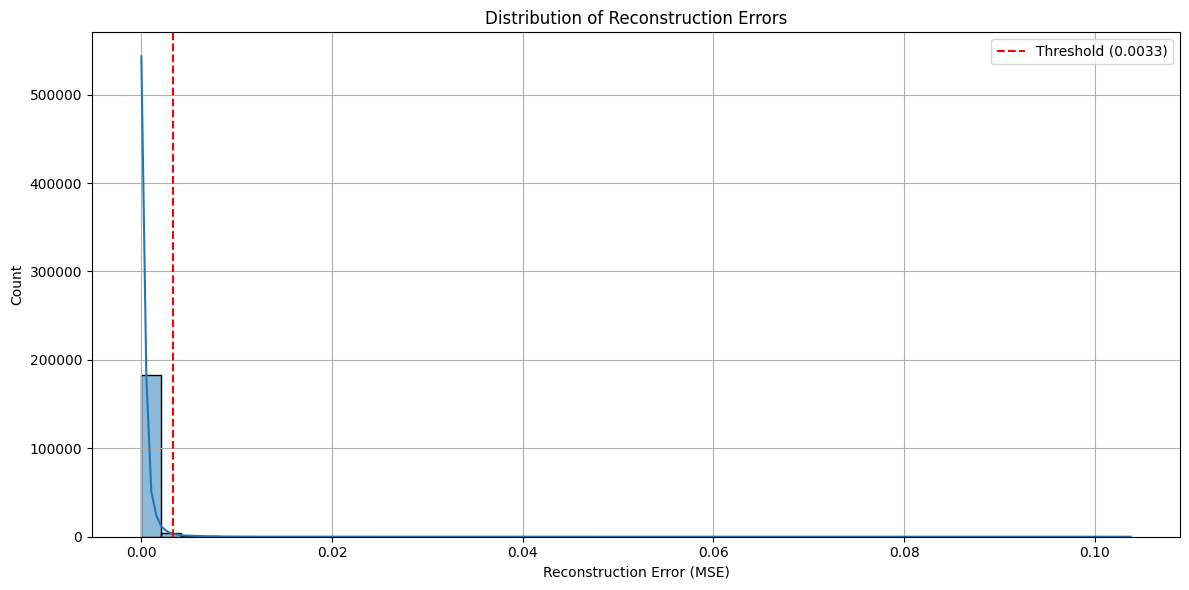

In [3]:
#########################
# PART 1: AUTOENCODER
#########################

# Build the autoencoder model
input_dim = X_train_ae.shape[1]

# Define the encoder
input_layer = Input(shape=(input_dim,))
# Encoder layers
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)

# Bottleneck layer
bottleneck = Dense(16, activation='relu')(encoder)

# Decoder layers
decoder = Dense(32, activation='relu')(bottleneck)
decoder = Dropout(0.2)(decoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dropout(0.2)(decoder)

# Output layer
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

# Create model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
print("Autoencoder Model Summary:")
autoencoder.summary()

# Train the autoencoder
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_ae = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=30,  # Reduced from 50 to make it run faster
    batch_size=32,
    validation_data=(X_test_ae, X_test_ae),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history_ae.history['loss'], label='Training Loss')
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the autoencoder model
autoencoder.save('/content/drive/MyDrive/Colab Notebooks/system_autoencoder.h5')

# Get reconstruction on the entire dataset
reconstructed = autoencoder.predict(df_scaled)

# Calculate reconstruction error (MSE per sample)
mse = np.mean(np.power(df_scaled - reconstructed, 2), axis=1)

# Calculate evaluation metrics
# MAE (Mean Absolute Error)
mae = mean_absolute_error(df_scaled, reconstructed)
# MSE (Mean Squared Error)
mse_overall = mean_squared_error(df_scaled, reconstructed)
# RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse_overall)

print("\n===== Autoencoder Evaluation Metrics =====")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse_overall:.6f}")
print(f"RMSE: {rmse:.6f}")

# Calculate per-feature reconstruction errors for analysis
feature_mae = np.mean(np.abs(df_scaled.values - reconstructed), axis=0)
feature_mse = np.mean(np.square(df_scaled.values - reconstructed), axis=0)
feature_rmse = np.sqrt(feature_mse)

# Create dataframe for feature-wise metrics
feature_metrics = pd.DataFrame({
    'Feature': numerical_features,
    'MAE': feature_mae,
    'MSE': feature_mse,
    'RMSE': feature_rmse
})

# Sort by RMSE to see which features have the highest reconstruction error
feature_metrics_sorted = feature_metrics.sort_values('RMSE', ascending=False)
print("\n===== Feature-wise Reconstruction Errors =====")
print(feature_metrics_sorted)

# Visualize feature-wise reconstruction errors
plt.figure(figsize=(14, 7))
plt.bar(feature_metrics_sorted['Feature'], feature_metrics_sorted['RMSE'])
plt.title('RMSE by Feature')
plt.xlabel('Feature')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Add reconstruction error to original dataframe
df['reconstruction_error'] = mse

# Determine anomaly threshold (mean + 2*std)
threshold = np.mean(mse) + 2 * np.std(mse)
print(f"Anomaly threshold: {threshold}")

# Flag anomalies
df['is_anomaly'] = (df['reconstruction_error'] > threshold).astype(int)
anomaly_count = df['is_anomaly'].sum()
print(f"Number of anomalies detected: {anomaly_count} ({anomaly_count/len(df)*100:.2f}%)")

# Plot reconstruction error
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['reconstruction_error'], label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'Threshold ({threshold:.4f})')
plt.fill_between(df.index, threshold, df['reconstruction_error'],
                 where=(df['reconstruction_error'] > threshold), color='red', alpha=0.3)
plt.title('Reconstruction Error Over Time')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display anomalies with highest reconstruction error
top_anomalies = df[df['is_anomaly'] == 1].sort_values('reconstruction_error', ascending=False).head(10)
print("Top 10 anomalies by reconstruction error:")
display(top_anomalies[['timestamp', 'cpu_usage', 'mem_usage', 'nginx_rps', 'reconstruction_error']])

# Feature contribution to anomalies
if anomaly_count > 0:
    plt.figure(figsize=(15, 8))
    anomaly_indices = df[df['is_anomaly'] == 1].index
    feature_errors = np.power(df_scaled.iloc[anomaly_indices].values -
                            reconstructed[anomaly_indices], 2)
    feature_error_df = pd.DataFrame(feature_errors, columns=numerical_features)
    feature_contribution = feature_error_df.mean().sort_values(ascending=False)

    plt.bar(feature_contribution.index, feature_contribution.values)
    plt.title('Feature Contribution to Anomalies')
    plt.xlabel('Features')
    plt.ylabel('Average Squared Error')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Visualize normal vs anomalous data points for top contributing features
if anomaly_count > 0:
    top_features = feature_contribution.head(6).index

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, feature in enumerate(top_features):
        ax = axes[i]
        sns.histplot(data=df, x=feature, hue='is_anomaly', bins=30, ax=ax,
                   palette={1: 'red', 0: 'blue'}, alpha=0.5, legend=i==0)
        ax.set_title(f'Distribution of {feature}')

    plt.tight_layout()
    plt.show()

# Visualize actual vs. reconstructed values for a few features
sample_size = min(1000, len(df))  # Limit to 1000 samples for visualization
sample_idx = np.random.choice(len(df), sample_size, replace=False)

for feature in numerical_features[:3]:  # Visualize first 3 features
    plt.figure(figsize=(15, 5))

    # Get original and reconstructed values
    original = df_scaled.iloc[sample_idx][feature].values
    reconstructed_values = reconstructed[sample_idx, numerical_features.index(feature)]

    # Plot scatter of original vs reconstructed
    plt.scatter(original, reconstructed_values, alpha=0.5)

    # Plot perfect reconstruction line
    min_val = min(original.min(), reconstructed_values.min())
    max_val = max(original.max(), reconstructed_values.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title(f'Original vs Reconstructed: {feature}')
    plt.xlabel('Original Value (Normalized)')
    plt.ylabel('Reconstructed Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Calculate error distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['reconstruction_error'], bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the labeled data
df.to_csv('/content/drive/MyDrive/Colab Notebooks/system_data_with_anomalies.csv', index=False)

In [4]:
#########################
# PART 2: LSTM MODEL
#########################

# Define function to create sequences for LSTM
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        # Use the label of the last timestep in the sequence
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Set sequence length
TIME_STEPS = 10

# Create sequences for LSTM
X_seq, y_seq = create_sequences(df_scaled, df['is_anomaly'], TIME_STEPS)

print(f"Sequence data shape: X={X_seq.shape}, y={y_seq.shape}")

# Split the data for LSTM training
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"Training data: X={X_train.shape}, y={y_train.shape}")
print(f"Testing data: X={X_test.shape}, y={y_test.shape}")

# Check class distribution
print(f"Training class distribution: {np.bincount(y_train.astype(int))}")
print(f"Testing class distribution: {np.bincount(y_test.astype(int))}")

# Calculate class weights for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(TIME_STEPS, len(numerical_features)),
         return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile LSTM model
lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("LSTM Model Summary:")
lstm_model.summary()

# Define callbacks
early_stopping_lstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_lstm = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/lstm_anomaly_detector.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the LSTM model
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping_lstm, checkpoint_lstm],
    verbose=1
)

Sequence data shape: X=(189371, 10, 14), y=(189371,)
Training data: X=(151496, 10, 14), y=(151496,)
Testing data: X=(37875, 10, 14), y=(37875,)
Training class distribution: [148850   2646]
Testing class distribution: [37407   468]
Class weights: {0: np.float64(0.5088881424252604), 1: np.float64(28.627362055933485)}
LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
4734/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8404 - loss: 0.5091
Epoch 1: val_loss improved from inf to 0.28087, saving model to /content/drive/MyDrive/Colab Notebooks/lstm_anomaly_detector.h5


4735/4735 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.8404 - loss: 0.5090 - val_accuracy: 0.9440 - val_loss: 0.2809
Epoch 2/30
4733/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8786 - loss: 0.3607
Epoch 2: val_loss improved from 0.28087 to 0.19952, saving model to /content/drive/MyDrive/Colab Notebooks/lstm_anomaly_detector.h5


4735/4735 ━━━━━━━━━━━━━━━━━━━━ 72s 15ms/step - accuracy: 0.8786 - loss: 0.3607 - val_accuracy: 0.9443 - val_loss: 0.1995
Epoch 3/30
4732/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8939 - loss: 0.3334
Epoch 3: val_loss did not improve from 0.19952
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - accuracy: 0.8939 - loss: 0.3333 - val_accuracy: 0.9534 - val_loss: 0.2144
Epoch 4/30
4733/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9077 - loss: 0.3055
Epoch 4: val_loss did not improve from 0.19952
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 70s 15ms/step - accuracy: 0.9077 - loss: 0.3055 - val_accuracy: 0.9301 - val_loss: 0.2521
Epoch 5/30
4733/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9099 - loss: 0.3021
Epoch 5: val_loss did not improve from 0.19952
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 0.9099 - loss: 0.3021 - val_accuracy: 0.9516 - val_loss: 0.2523
Epoch 6/30
4733/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9167 - loss: 0.2963
Epoch 6: val_loss i

4735/4735 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - accuracy: 0.9167 - loss: 0.2963 - val_accuracy: 0.9790 - val_loss: 0.1209
Epoch 7/30
4733/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9121 - loss: 0.3015
Epoch 7: val_loss did not improve from 0.12091
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - accuracy: 0.9121 - loss: 0.3015 - val_accuracy: 0.9703 - val_loss: 0.1532
Epoch 8/30
4734/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9150 - loss: 0.2892
Epoch 8: val_loss did not improve from 0.12091
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.9150 - loss: 0.2892 - val_accuracy: 0.9607 - val_loss: 0.1384
Epoch 9/30
4733/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9189 - loss: 0.2956
Epoch 9: val_loss did not improve from 0.12091
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 77s 16ms/step - accuracy: 0.9189 - loss: 0.2956 - val_accuracy: 0.9657 - val_loss: 0.1366
Epoch 10/30
4734/4735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9222 - loss: 0.2839
Epoch 10: val_loss

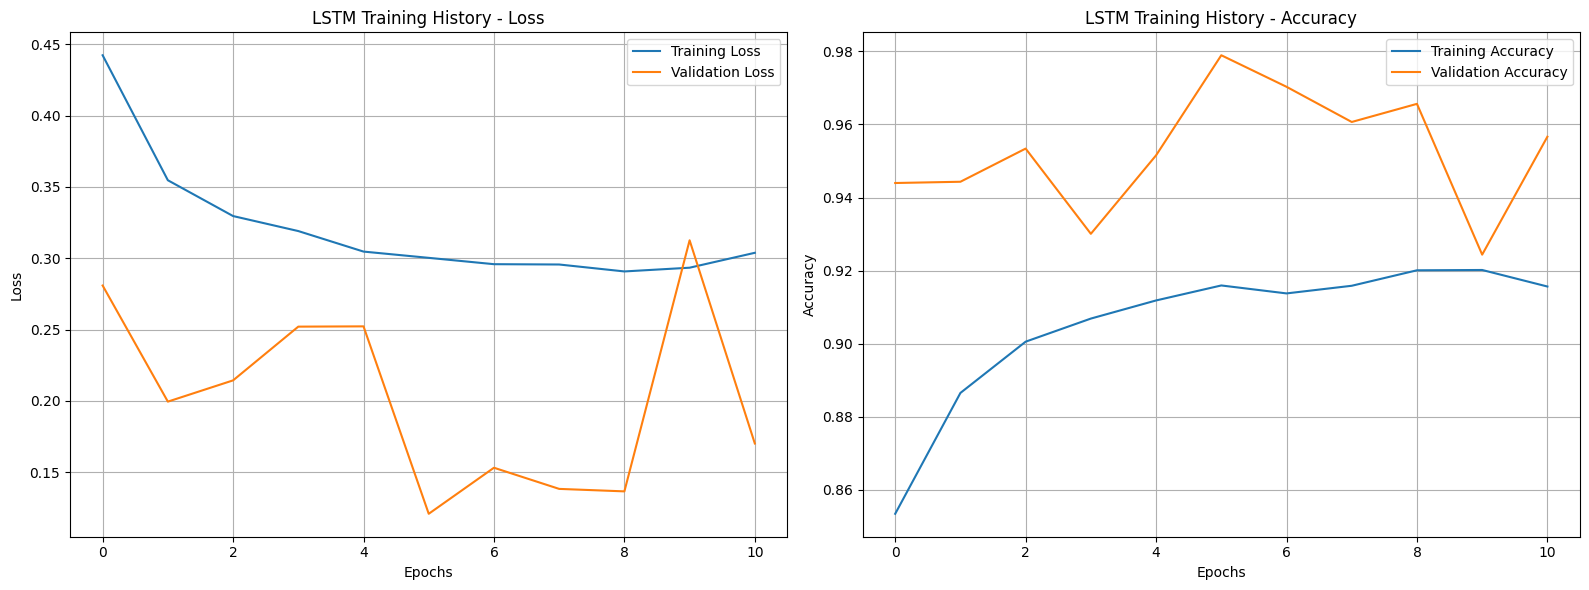

1184/1184 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

===== LSTM Model Evaluation Metrics =====
Accuracy: 0.9790
Precision: 0.2987
Recall: 0.5214
F1-Score: 0.3798


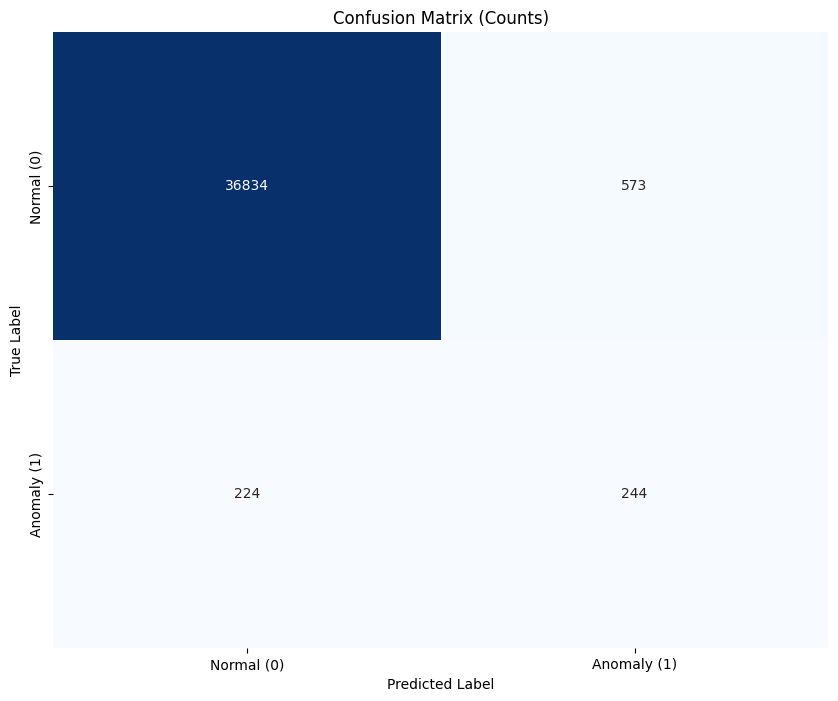

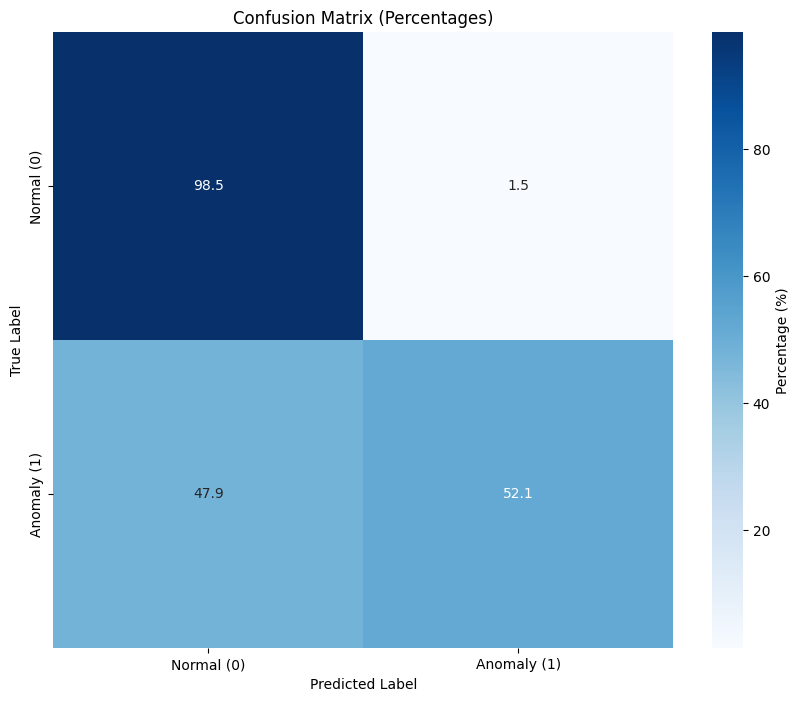

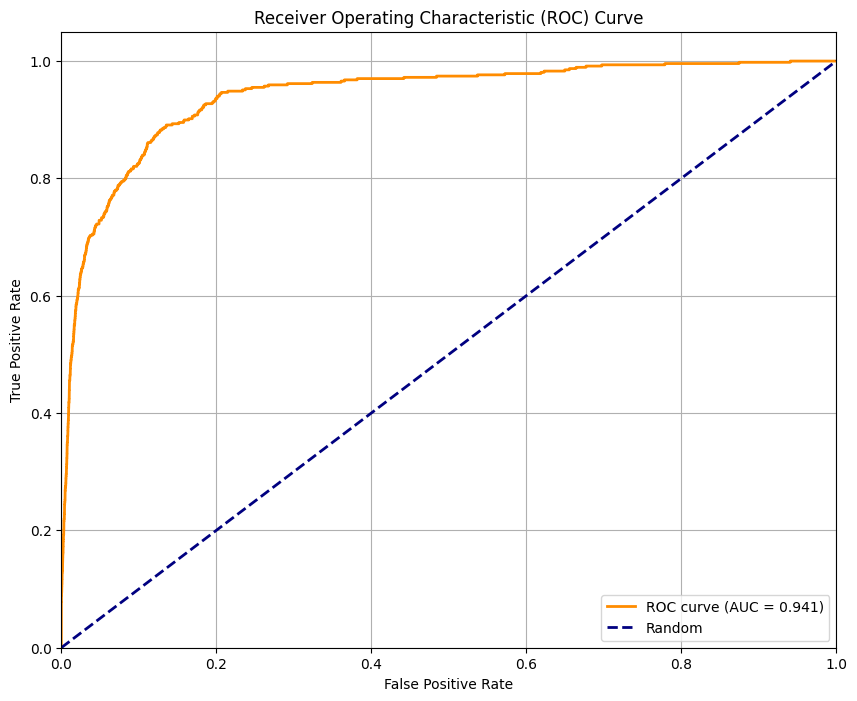

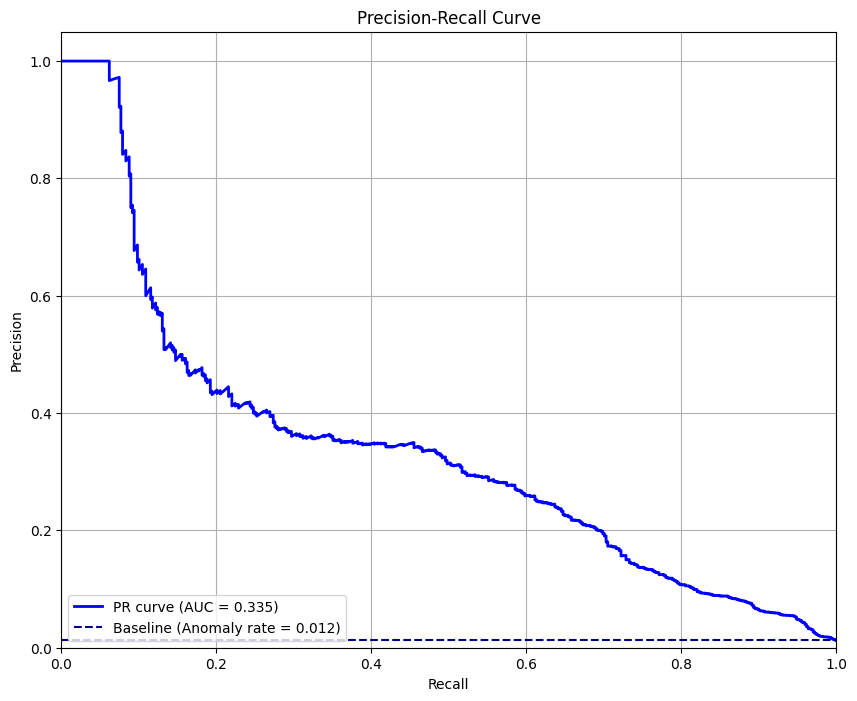

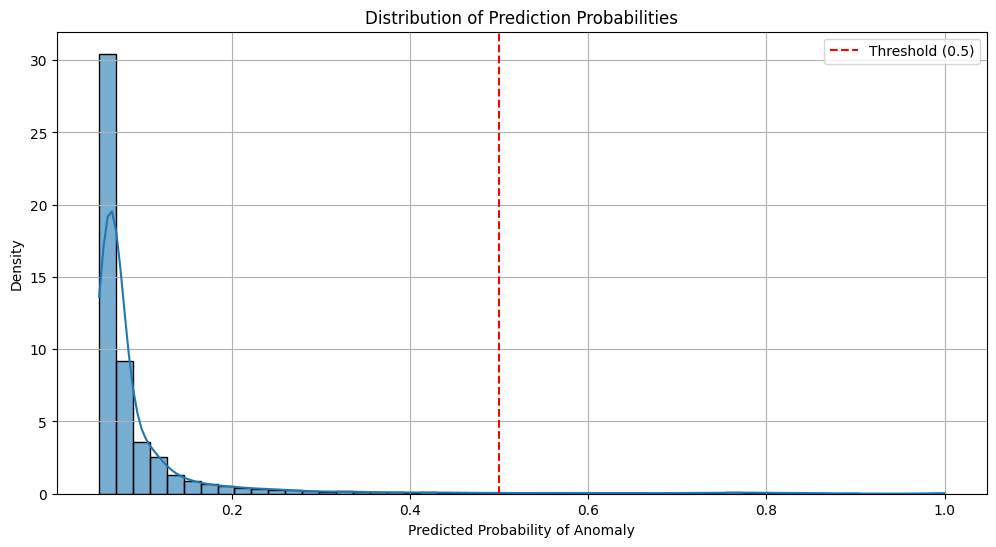

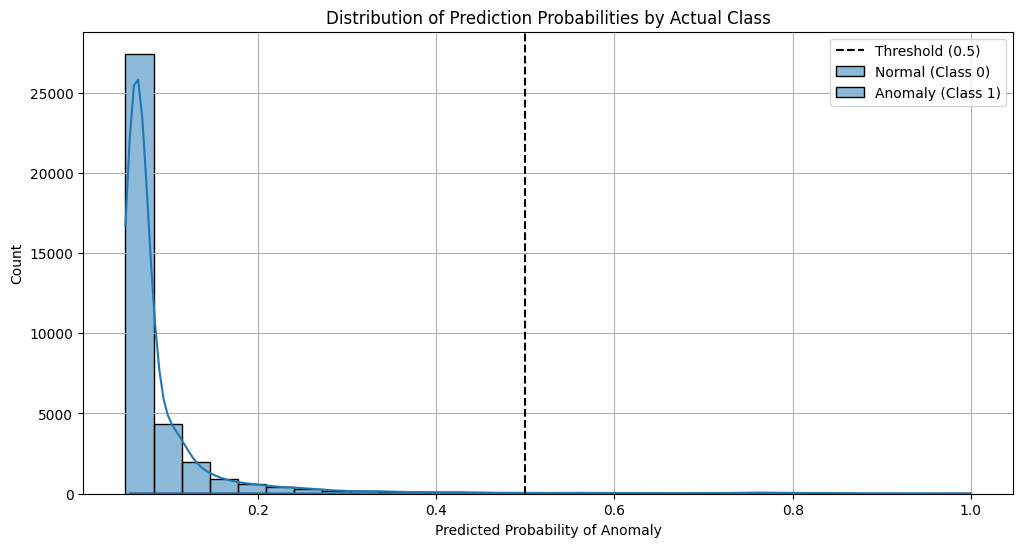

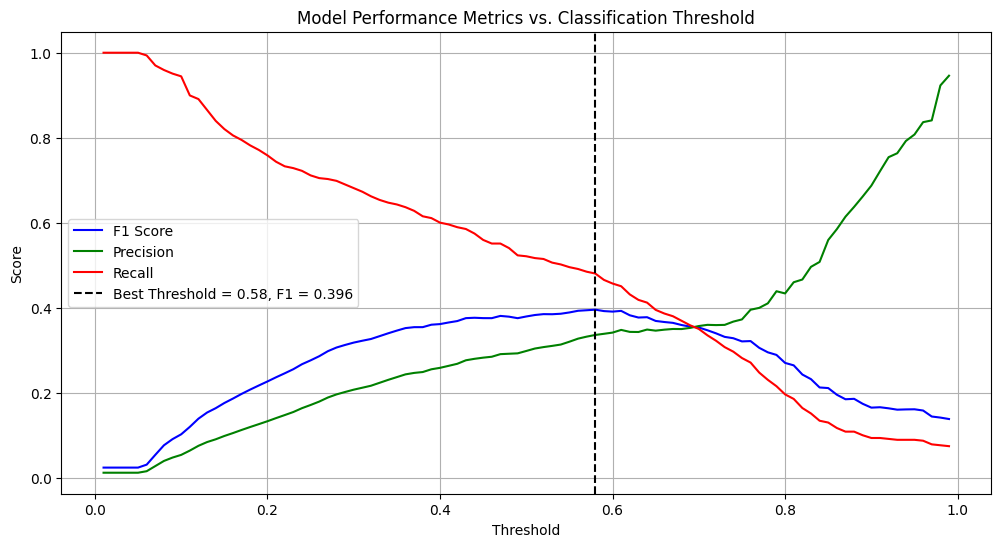

Optimal threshold for F1 score: 0.5800, F1 score: 0.3958


ValueError: where size (40000) does not match 'x' size (200)

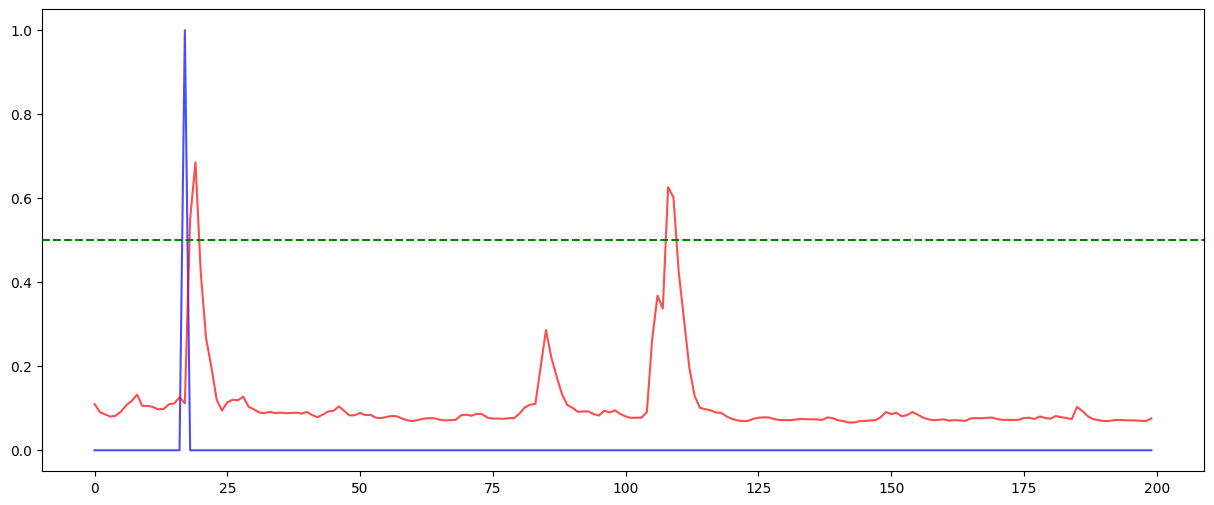

In [5]:
#########################
# DETAILED LSTM VISUALIZATIONS
#########################

# 1. Plot LSTM training history - Loss and Accuracy
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate LSTM model on test set
y_pred_proba = lstm_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n===== LSTM Model Evaluation Metrics =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 2. Plot confusion matrix with percentages
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Normal (0)', 'Anomaly (1)'])
plt.yticks([0.5, 1.5], ['Normal (0)', 'Anomaly (1)'])
plt.show()

# 3. Plot percentage confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', cbar=True,
            cbar_kws={'label': 'Percentage (%)'})
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Normal (0)', 'Anomaly (1)'])
plt.yticks([0.5, 1.5], ['Normal (0)', 'Anomaly (1)'])
plt.show()

# 4. Plot ROC curve and calculate AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 5. Plot Precision-Recall curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='blue', lw=2,
         label=f'PR curve (AUC = {pr_auc:.3f})')
plt.axhline(y=sum(y_test)/len(y_test), color='navy', linestyle='--',
            label=f'Baseline (Anomaly rate = {sum(y_test)/len(y_test):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# 6. Distribution of prediction probabilities
plt.figure(figsize=(12, 6))
sns.histplot(
    y_pred_proba,
    bins=50,
    kde=True,
    stat="density",
    color="blue",
    alpha=0.6
)
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold (0.5)')
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Predicted Probability of Anomaly')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# 7. Distribution of prediction probabilities by actual class
plt.figure(figsize=(12, 6))
# Get probabilities for each class
normal_probs = y_pred_proba[y_test == 0]
anomaly_probs = y_pred_proba[y_test == 1]

sns.histplot(normal_probs, bins=30, alpha=0.5, color='blue',
             label='Normal (Class 0)', kde=True)
sns.histplot(anomaly_probs, bins=30, alpha=0.5, color='red',
             label='Anomaly (Class 1)', kde=True)
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
plt.title('Distribution of Prediction Probabilities by Actual Class')
plt.xlabel('Predicted Probability of Anomaly')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# 8. Threshold optimization plot - F1 Score
# Calculate metrics for different thresholds
thresholds = np.linspace(0.01, 0.99, 99)
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_t = (y_pred_proba > threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))
    precision_scores.append(precision_score(y_test, y_pred_t))
    recall_scores.append(recall_score(y_test, y_pred_t))

# Find best threshold for F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Plot metrics vs thresholds
plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores, 'b-', label='F1 Score')
plt.plot(thresholds, precision_scores, 'g-', label='Precision')
plt.plot(thresholds, recall_scores, 'r-', label='Recall')
plt.axvline(x=best_threshold, color='k', linestyle='--',
            label=f'Best Threshold = {best_threshold:.2f}, F1 = {best_f1:.3f}')
plt.title('Model Performance Metrics vs. Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal threshold for F1 score: {best_threshold:.4f}, F1 score: {best_f1:.4f}")

# 9. Time series of actual vs predicted over sample periods
sample_size = min(200, len(y_test))  # Show last 200 points or fewer if less available
indices = np.arange(len(y_test) - sample_size, len(y_test))
time_indices = np.arange(len(indices))

plt.figure(figsize=(15, 6))
plt.plot(time_indices, y_test[indices], 'b-', label='Actual', alpha=0.7)
plt.plot(time_indices, y_pred_proba[indices], 'r-', label='Predicted Probability', alpha=0.7)
plt.axhline(y=0.5, color='g', linestyle='--', label='Threshold (0.5)')
plt.fill_between(time_indices, 0, 1,
                 where=(y_pred_proba[indices] > 0.5) & (y_test[indices] == 1),
                 facecolor='lime', alpha=0.3, label='True Positive')
plt.fill_between(time_indices, 0, 1,
                 where=(y_pred_proba[indices] > 0.5) & (y_test[indices] == 0),
                 facecolor='red', alpha=0.3, label='False Positive')
plt.fill_between(time_indices, 0, 1,
                 where=(y_pred_proba[indices] <= 0.5) & (y_test[indices] == 1),
                 facecolor='orange', alpha=0.3, label='False Negative')
plt.title('Time Series of Actual vs Predicted Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Score / Class')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Analysis of model performance by feature
test_data_indices = np.arange(train_size, train_size + len(X_test))
test_df = df.iloc[test_data_indices].copy()
test_df['predicted_proba'] = y_pred_proba
test_df['predicted'] = y_pred

# Feature impact on misclassifications
def analyze_feature_impact():
    # Get misclassifications
    misclassified = test_df[test_df['is_anomaly'] != test_df['predicted']]

    # Get false positives and false negatives
    fp = test_df[(test_df['is_anomaly'] == 0) & (test_df['predicted'] == 1)]
    fn = test_df[(test_df['is_anomaly'] == 1) & (test_df['predicted'] == 0)]

    if len(fp) > 0 and len(fn) > 0:
        # Compare feature values for misclassifications
        fig, axes = plt.subplots(5, 3, figsize=(18, 25))
        axes = axes.flatten()

        for i, feature in enumerate(numerical_features):
            if i >= len(axes):
                break

            ax = axes[i]
            # Plot feature distribution by prediction result
            sns.boxplot(x='predicted', y=feature, hue='is_anomaly',
                       data=test_df, palette='Set3', ax=ax)
            ax.set_title(f'Distribution of {feature}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel(feature)
            if i > 0:
                ax.get_legend().remove()

        plt.tight_layout()
        plt.show()

        # Plot feature importance for misclassifications
        feature_importance = {}

        # Calculate normalized mean difference between FP and normal, and FN and anomalies
        for feature in numerical_features:
            # For false positives: how different from normal data?
            normal_mean = test_df[test_df['is_anomaly'] == 0][feature].mean()
            normal_std = test_df[test_df['is_anomaly'] == 0][feature].std()

            fp_diff = abs(fp[feature].mean() - normal_mean) / max(1e-10, normal_std)

            # For false negatives: how different from anomalous data?
            anomaly_mean = test_df[test_df['is_anomaly'] == 1][feature].mean()
            anomaly_std = test_df[test_df['is_anomaly'] == 1][feature].std()

            fn_diff = abs(fn[feature].mean() - anomaly_mean) / max(1e-10, anomaly_std)

            # Overall importance: average of both
            feature_importance[feature] = (fp_diff + fn_diff) / 2

        # Plot feature importance
        importance_df = pd.DataFrame.from_dict(feature_importance, orient='index',
                                               columns=['Importance'])
        importance_df = importance_df.sort_values('Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x=importance_df.index, y='Importance', data=importance_df)
        plt.title('Feature Importance for Misclassifications')
        plt.xlabel('Features')
        plt.ylabel('Importance Score (Normalized Difference)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

# Run feature impact analysis
analyze_feature_impact()

# Save evaluation metrics to file
with open('/content/drive/MyDrive/Colab Notebooks/lstm_model_evaluation.txt', 'w') as f:
    f.write("===== LSTM Model Evaluation Metrics =====\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")
    f.write(f"ROC AUC: {roc_auc:.4f}\n")
    f.write(f"PR AUC: {pr_auc:.4f}\n")
    f.write(f"Optimal threshold for F1: {best_threshold:.4f}\n")
    f.write(f"\nConfusion Matrix:\n{cm}")

print("Evaluation metrics saved to Google Drive")

In [6]:
#########################
# PART 3: REAL-TIME DETECTION
#########################

def detect_anomalies_realtime(new_data, lstm_model, scaler, time_steps=10):
    """
    Detect anomalies in new data in real-time

    Parameters:
    -----------
    new_data : pandas DataFrame
        New data points to check for anomalies (must have all needed numerical features)
    lstm_model : Keras model
        Trained LSTM model
    scaler : MinMaxScaler
        Fitted scaler to normalize data
    time_steps : int
        Number of time steps used in LSTM training

    Returns:
    --------
    Dictionary with anomaly predictions and probabilities
    """
    # Ensure we have the required features
    required_features = numerical_features
    missing_features = [f for f in required_features if f not in new_data.columns]

    if missing_features:
        return {
            "error": f"Missing required features: {missing_features}",
            "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

    # Handle missing values
    data = new_data[required_features].fillna(0).copy()

    # Scale the data
    data_scaled = scaler.transform(data)

    # If we have at least time_steps points, we can make a prediction
    if len(data) >= time_steps:
        # Get the most recent time_steps points
        recent_data = data_scaled[-time_steps:]

        # Reshape for LSTM input format [samples, time_steps, features]
        X_new = recent_data.reshape(1, time_steps, len(required_features))

        # Make prediction
        anomaly_prob = lstm_model.predict(X_new)[0][0]

        # Use optimal threshold if available, otherwise default to 0.5
        threshold = best_threshold if 'best_threshold' in locals() else 0.5
        is_anomaly = bool(anomaly_prob > threshold)

        return {
            "is_anomaly": is_anomaly,
            "anomaly_probability": float(anomaly_prob),
            "threshold": float(threshold),
            "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    else:
        return {
            "error": "Not enough data points",
            "required": time_steps,
            "provided": len(data),
            "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

# Example of using the real-time detection function
def simulation_example():
    # For demonstration: get some sample points from test data
    sample_history = df.iloc[-20:-10][numerical_features].reset_index(drop=True)

    # Simulate a new normal data point
    new_normal_point = df.iloc[-9:-8][numerical_features].copy()

    # Simulate an anomalous data point (high CPU usage)
    new_anomaly_point = df.iloc[-9:-8][numerical_features].copy()
    new_anomaly_point['cpu_usage'] = new_anomaly_point['cpu_usage'] * 3

    # Combine history with new point
    data_with_normal = pd.concat([sample_history, new_normal_point]).reset_index(drop=True)
    data_with_anomaly = pd.concat([sample_history, new_anomaly_point]).reset_index(drop=True)

    # Make predictions
    result_normal = detect_anomalies_realtime(data_with_normal, lstm_model, scaler, TIME_STEPS)
    result_anomaly = detect_anomalies_realtime(data_with_anomaly, lstm_model, scaler, TIME_STEPS)
    print(result_normal)
    print(result_anomaly)

    print("\n===== Real-time Detection Example =====")
    print("Normal data point result:", result_normal)
    print("Anomalous data point result:", result_anomaly)

# Run the simulation example
simulation_example()

# Function to simulate real-time monitoring
def setup_realtime_monitoring():
    """Simulate real-time monitoring with a buffer of recent data points"""

    # Start with a buffer of historical data (last TIME_STEPS points)
    buffer = df.iloc[-30:-20][numerical_features].reset_index(drop=True)
    print(f"Starting with buffer of {len(buffer)} historical data points")

    # Initialize arrays to store results for visualization
    timestamps = []
    probabilities = []
    anomaly_status = []
    threshold_values = []

    # Simulate 10 new incoming data points
    for i in range(10):
        print(f"\n--- Iteration {i+1} ---")

        # Simulate new data point (make some anomalous)
        if i % 3 == 0:  # Every 3rd point is anomalous
            new_point = df.iloc[-15+i:1-14+i][numerical_features].copy()
            new_point['cpu_usage'] = new_point['cpu_usage'] * 2  # Make it anomalous
            print("Created anomalous data point (high CPU)")
        else:
            new_point = df.iloc[-15+i:1-14+i][numerical_features].copy()
            print("Created normal data point")

        # Add to buffer
        buffer = pd.concat([buffer, new_point]).reset_index(drop=True)

        # Keep only the most recent TIME_STEPS points
        if len(buffer) > TIME_STEPS:
            buffer = buffer.iloc[-TIME_STEPS:].reset_index(drop=True)

        # Detect anomalies
        result = detect_anomalies_realtime(buffer, lstm_model, scaler, TIME_STEPS)

        # Store results for visualization
        timestamps.append(str(i+1))

        # Print result
        if "error" in result:
            print(f"Error: {result['error']}")
            probabilities.append(0)
            anomaly_status.append("Error")
            threshold_values.append(0.5)
        else:
            probabilities.append(result["anomaly_probability"])
            anomaly_status.append("Anomaly" if result["is_anomaly"] else "Normal")
            threshold_values.append(result["threshold"])

            if result["is_anomaly"]:
                print(f"ALERT! Anomaly detected with probability {result['anomaly_probability']:.4f}")
            else:
                print(f"Normal data (probability of anomaly: {result['anomaly_probability']:.4f})")

        # In a real system, you would wait 15 seconds here
        time.sleep(1)  # For simulation, we just wait 1 second

    print("\nReal-time monitoring simulation complete")

    # Visualize results
    plt.figure(figsize=(15, 8))

    # Plot anomaly probabilities
    plt.plot(timestamps, probabilities, 'b-o', label='Anomaly Probability')

    # Plot threshold
    plt.plot(timestamps, threshold_values, 'r--', label='Threshold')

    # Highlight anomalies
    for i, status in enumerate(anomaly_status):
        if status == "Anomaly":
            plt.scatter(timestamps[i], probabilities[i], color='red', s=100, zorder=5,
                       label='_' if i > 0 else 'Detected Anomaly')

    # Add annotations
    for i, prob in enumerate(probabilities):
        plt.annotate(f'{prob:.3f}', (timestamps[i], prob + 0.02),
                    ha='center', va='bottom', fontsize=9)

    plt.title('Real-time Anomaly Detection Simulation')
    plt.xlabel('Time Step')
    plt.ylabel('Anomaly Probability')
    plt.ylim(0, 1.1)
    plt.grid(True)
    plt.legend()
    plt.show()

# Run the real-time monitoring simulation with visualization
# setup_realtime_monitoring()

# Example function to load models and detect anomalies
def load_models_and_detect(new_data_csv):
    """
    Load saved models and detect anomalies in new data

    Parameters:
    -----------
    new_data_csv : str
        Path to CSV with new data

    Returns:
    --------
    DataFrame with anomaly predictions
    """
    # Load models and scaler
    lstm_model = load_model('/content/drive/MyDrive/Colab Notebooks/lstm_anomaly_detector.h5')
    scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/feature_scaler.pkl')

    # Load new data
    new_data = pd.read_csv(new_data_csv)

    # Detect anomalies
    result = detect_anomalies_realtime(new_data, lstm_model, scaler, TIME_STEPS)

    return result

# Usage example (commented out)
"""
# How to use in production:
result = load_models_and_detect('path_to_new_data.csv')
if result.get('is_anomaly', False):
    # Send alert or take action
    print(f"ALERT: Anomaly detected! Probability: {result['anomaly_probability']}")
else:
    print("System operating normally")
"""

print("\nModel training, visualization, and evaluation complete!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
{'is_anomaly': False, 'anomaly_probability': 0.07159429043531418, 'threshold': 0.5, 'timestamp': '2025-03-19 01:38:52'}
{'is_anomaly': False, 'anomaly_probability': 0.07159429043531418, 'threshold': 0.5, 'timestamp': '2025-03-19 01:38:52'}

===== Real-time Detection Example =====
Normal data point result: {'is_anomaly': False, 'anomaly_probability': 0.07159429043531418, 'threshold': 0.5, 'timestamp': '2025-03-19 01:38:52'}
Anomalous data point result: {'is_anomaly': False, 'anomaly_probability': 0.07159429043531418, 'threshold': 0.5, 'timestamp': '2025-03-19 01:38:52'}

Model training, visualization, and evaluation complete!


In [ ]:
result = load_models_and_detect('path_to_new_data.csv')
if result.get('is_anomaly', False):
    # Send alert or take action
    print(f"ALERT: Anomaly detected! Probability: {result['anomaly_probability']}")
else:
    print("System operating normally")